In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
from create_matrix import *
import os
import sys
from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
from sklearn.model_selection import train_test_split, KFold
from common import compute_rmse_fraction
from common import compute_rmse

appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}
APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']

In [2]:
def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [4]:
year = 2014
region = "SanDiego"
sd_df, sd_dfc = create_matrix_single_region("SanDiego", year)
sd_tensor = get_tensor(sd_df, sd_dfc)
region = "Austin"
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)

In [26]:
def cost_reg(H, A, T, lam, A_known, E_np_masked):
    HA = np.einsum('Ma, Nab -> MNb', H, A)
    HAT = np.einsum('MNb, Ob -> MNO', HA, T)
    mask = ~np.isnan(E_np_masked)
    error1 = (HAT - E_np_masked)[mask].flatten()
    
#     error2 = (np.multiply(P, (A - A_known))).flatten()
    error2 = (A - A_known).flatten()
    
    return np.sqrt((error1 ** 2).mean()) + lam*np.sqrt((error2 ** 2).mean())

def learn_HAT_reg(lam, E_np_masked, a, b, A_known, num_iter=2000, lr=0.1, dis=False, cost_function='abs', H_known=None,
               T_known=None, random_seed=0, decay_mul=1, batchsize=None, aggregate_constraint=False):
    np.random.seed(0)
    cost = cost_reg
    mg = multigrad(cost, argnums=[0, 1, 2])
    
    params = {}
    params['M'], params['N'], params['O'] = E_np_masked.shape
    params['a'] = a
    params['b'] = b
    H_dim_chars = list(cases[case]['HA'].split(",")[0].strip())
    H_dim = tuple(params[x] for x in H_dim_chars)
    A_dim_chars = list(cases[case]['HA'].split(",")[1].split("-")[0].strip())
    A_dim = tuple(params[x] for x in A_dim_chars)
    T_dim_chars = list(cases[case]['HAT'].split(",")[1].split("-")[0].strip())
    T_dim = tuple(params[x] for x in T_dim_chars)
    H = np.random.rand(*H_dim)
    A = np.random.rand(*A_dim)
    T = np.random.rand(*T_dim)

    # GD procedure
    for i in range(num_iter):
        del_h, del_a, del_t = mg(H, A, T, lam, A_known, E_np_masked)
        H -= lr * del_h
        A -= lr * del_a
        T -= lr * del_t
        
        # Projection to non-negative space
        H[H < 0] = 0
        A[A < 0] = 0
        T[T < 0] = 0
    
        if i % 500 == 0:
            if dis:
                print(cost(H, A, T, A_known, E_np_masked))
    return H, A, T    

In [16]:
from scipy.optimize import nnls

n_splits = 10
case = 2
a = 2
b = 3
cost = 'abs'


pred_transfer_const_reg_1 = {}

for random_seed in range(10):
    
    pred_normal_const[random_seed] = {}
    pred_transfer_const_reg[random_seed] = {}
    pred_transfer_const[random_seed] = {}
    
    for appliance in APPLIANCES_ORDER:
        pred_normal_const[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}
        pred_transfer_const_reg[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}
        pred_transfer_const[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}


kf = KFold(n_splits=n_splits)
kf = KFold(n_splits=n_splits)
for random_seed in range(10):
    print "random seed: ", random_seed
    for train_percentage in range(10, 110, 10):
        print "training percentage: ", train_percentage
        rd = 0
        for train_max, test in kf.split(sd_df):
                print "round: ", rd


                num_train = int((train_percentage*len(train_max)/100)+0.5)
                num_test = len(test)

                # get the random training data from train_max based on then random seed
                if train_percentage==100:
                    train = train_max
                else:
                    train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)

                # get the index of training and testing data
                train_ix = sd_df.index[train]
                test_ix = sd_df.index[test]
                print "test_ix: ", test_ix

                # create the tensor
                train_test_ix = np.concatenate([test_ix, train_ix])
                df_t, dfc_t = sd_df.ix[train_test_ix], sd_dfc.ix[train_test_ix]
                tensor = get_tensor(df_t, dfc_t)


                ############################################################################################
                # Normal learning: no constant constraint, no A_known, with learn_HAT
                ############################################################################################
                tensor_copy = tensor.copy()
                tensor_copy[:num_test, 1:, :] = np.NaN
                H, A, T = learn_HAT(case, tensor_copy, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost, T_known = np.ones(12).reshape(-1, 1))

                # get the prediction
                HAT = multiply_case(H, A, T, case)
                for appliance in APPLIANCES_ORDER:
                    pred_normal_const[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))


                #############################################################################################
                # transfer learning: constant constraint, with A_known = A_a_const, with learn_HAT_constant
                ############################################################################################
                tensor_copy = tensor.copy()
                tensor_copy[:num_test, 1:, :] = np.NaN
                H, A, T = learn_HAT(case, tensor_copy, a, b, num_iter=2000, lr=0.1, dis=False, cost_function=cost, A_known=A_a_const, T_known = np.ones(12).reshape(-1, 1))

                # get the prediction
                HAT = multiply_case(H, A, T, case)
                for appliance in APPLIANCES_ORDER:
                    pred_transfer_const[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))


                #############################################################################################
                # transfer learning with regularization: constant constraint, with A_known = A_a_const, with learn_HAT_constant
                ############################################################################################
                tensor_copy = tensor.copy()
                tensor_copy[:num_test, 1:, :] = np.NaN
                H, A, T = learn_HAT_reg(0.1, tensor_copy, a, b, A_a_const, num_iter=2000, lr=0.1, dis=False, T_known=np.ones(12).reshape(-1, 1))
                # get the prediction
                HAT = multiply_case(H, A, T, case)
                for appliance in APPLIANCES_ORDER:
                    pred_transfer_const_reg[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))


                rd += 1

random seed:  0
training percentage:  10
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
training percentage:  20
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
te

In [36]:
from scipy.optimize import nnls

n_splits = 10
case = 2
a = 2
b = 3
cost = 'abs'


pred_transfer_const_reg_1 = {}

for random_seed in range(10):
    
    pred_transfer_const_reg_1[random_seed] = {}
    
    for appliance in APPLIANCES_ORDER:
        pred_transfer_const_reg_1[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}

kf = KFold(n_splits=n_splits)
for random_seed in range(10):
    print "random seed: ", random_seed
    for train_percentage in range(10, 110, 10):
        print "training percentage: ", train_percentage
        rd = 0
        for train_max, test in kf.split(sd_df):
                print "round: ", rd
                num_train = int((train_percentage*len(train_max)/100)+0.5)
                num_test = len(test)

                # get the random training data from train_max based on then random seed
                if train_percentage==100:
                    train = train_max
                else:
                    train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)

                # get the index of training and testing data
                train_ix = sd_df.index[train]
                test_ix = sd_df.index[test]
                print "test_ix: ", test_ix

                # create the tensor
                train_test_ix = np.concatenate([test_ix, train_ix])
                df_t, dfc_t = sd_df.ix[train_test_ix], sd_dfc.ix[train_test_ix]
                tensor = get_tensor(df_t, dfc_t)

                #############################################################################################
                # transfer learning with regularization: constant constraint, with A_known = A_a_const, with learn_HAT_constant
                ############################################################################################
                tensor_copy = tensor.copy()
                tensor_copy[:num_test, 1:, :] = np.NaN
                H, A, T = learn_HAT_reg(1, tensor_copy, a, b, A_a_const, num_iter=2000, lr=0.1, dis=False, T_known=np.ones(12).reshape(-1, 1))
                # get the prediction
                HAT = multiply_case(H, A, T, case)
                for appliance in APPLIANCES_ORDER:
                    pred_transfer_const_reg_1[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))


                rd += 1

random seed:  0
training percentage:  10
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
training percentage:  20
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
te

In [37]:
from scipy.optimize import nnls

n_splits = 10
case = 2
a = 2
b = 3
cost = 'abs'


pred_transfer_const_reg_10 = {}

for random_seed in range(10):
    
    pred_transfer_const_reg_10[random_seed] = {}
    
    for appliance in APPLIANCES_ORDER:
        pred_transfer_const_reg_10[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}

kf = KFold(n_splits=n_splits)
for random_seed in range(10):
    print "random seed: ", random_seed
    for train_percentage in range(10, 110, 10):
        print "training percentage: ", train_percentage
        rd = 0
        for train_max, test in kf.split(sd_df):
                print "round: ", rd
                num_train = int((train_percentage*len(train_max)/100)+0.5)
                num_test = len(test)

                # get the random training data from train_max based on then random seed
                if train_percentage==100:
                    train = train_max
                else:
                    train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)

                # get the index of training and testing data
                train_ix = sd_df.index[train]
                test_ix = sd_df.index[test]
                print "test_ix: ", test_ix

                # create the tensor
                train_test_ix = np.concatenate([test_ix, train_ix])
                df_t, dfc_t = sd_df.ix[train_test_ix], sd_dfc.ix[train_test_ix]
                tensor = get_tensor(df_t, dfc_t)

                #############################################################################################
                # transfer learning with regularization: constant constraint, with A_known = A_a_const, with learn_HAT_constant
                ############################################################################################
                tensor_copy = tensor.copy()
                tensor_copy[:num_test, 1:, :] = np.NaN
                H, A, T = learn_HAT_reg(10, tensor_copy, a, b, A_a_const, num_iter=2000, lr=0.1, dis=False, T_known=np.ones(12).reshape(-1, 1))
                # get the prediction
                HAT = multiply_case(H, A, T, case)
                for appliance in APPLIANCES_ORDER:
                    pred_transfer_const_reg_10[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))


                rd += 1

random seed:  0
training percentage:  10
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
training percentage:  20
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
round:  3
te

In [38]:
out_normal_const = {}
for random_seed in range(10):
    out_normal_const[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out_normal_const[random_seed][appliance] = {}
        for f in range(10,110,10):
            s = pd.concat(pred_normal_const[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_normal_const[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_normal_const[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [39]:
out_transfer_const = {}
for random_seed in range(10):
    out_transfer_const[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out_transfer_const[random_seed][appliance] = {}
        for f in range(10,110,10):
            s = pd.concat(pred_transfer_const[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_transfer_const[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_transfer_const[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [40]:
out_transfer_const_reg = {}
for random_seed in range(10):
    out_transfer_const_reg[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out_transfer_const_reg[random_seed][appliance] = {}
        for f in range(10,110,10):
            s = pd.concat(pred_transfer_const_reg[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_transfer_const_reg[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_transfer_const_reg[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [41]:
out_transfer_const_reg_1 = {}
for random_seed in range(10):
    out_transfer_const_reg_1[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out_transfer_const_reg_1[random_seed][appliance] = {}
        for f in range(10,110,10):
            s = pd.concat(pred_transfer_const_reg_1[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_transfer_const_reg_1[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_transfer_const_reg_1[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [42]:
out_transfer_const_reg_10 = {}
for random_seed in range(10):
    out_transfer_const_reg_10[random_seed] = {}
       
    for appliance in APPLIANCES_ORDER[1:]:
        out_transfer_const_reg_10[random_seed][appliance] = {}
        for f in range(10,110,10):
            s = pd.concat(pred_transfer_const_reg_10[random_seed][appliance][f]).ix[sd_df.index]
            if appliance=="hvac":
                out_transfer_const_reg_10[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_transfer_const_reg_10[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [43]:
mean_out_transfer_const = pd.Panel(out_transfer_const).mean(axis=0)
mean_out_normal_const = pd.Panel(out_normal_const).mean(axis=0)
mean_out_transfer_const_reg = pd.Panel(out_transfer_const_reg).mean(axis=0)
mean_out_transfer_const_reg_1 = pd.Panel(out_transfer_const_reg_1).mean(axis=0)

mean_out_transfer_const_reg_10 = pd.Panel(out_transfer_const_reg_10).mean(axis=0)


# df_out_normal = pd.DataFrame(out_normal)]

mean_out_normal_const = mean_out_normal_const.rename(columns={'dw':'dw_normal_const', 'fridge':'fridge_normal_const', 'hvac':'hvac_normal_const',
                                             'mw':'mw_normal_const', 'oven':"oven_normal_const", 'wm':'wm_normal_const'})
mean_out_transfer_const = mean_out_transfer_const.rename(columns={'dw':'dw_transfer_const', 'fridge':'fridge_transfer_const', 'hvac':'hvac_transfer_const',
                                             'mw':'mw_transfer_const', 'oven':"oven_transfer_const", 'wm':'wm_transfer_const'})
mean_out_transfer_const_reg = mean_out_transfer_const_reg.rename(columns={'dw':'dw_transfer_const_reg_0.1', 'fridge':'fridge_transfer_const_reg_0.1', 'hvac':'hvac_transfer_const_reg_0.1',
                                             'mw':'mw_transfer_const_reg_0.1', 'oven':"oven_transfer_const_reg_0.1", 'wm':'wm_transfer_const_reg_0.1'})
mean_out_transfer_const_reg_1 = mean_out_transfer_const_reg_1.rename(columns={'dw':'dw_transfer_const_reg_1', 'fridge':'fridge_transfer_const_reg_1', 'hvac':'hvac_transfer_const_reg_1',
                                             'mw':'mw_transfer_const_reg_1', 'oven':"oven_transfer_const_reg_1", 'wm':'wm_transfer_const_reg_1'})
mean_out_transfer_const_reg_10 = mean_out_transfer_const_reg_10.rename(columns={'dw':'dw_transfer_const_reg_10', 'fridge':'fridge_transfer_const_reg_10', 'hvac':'hvac_transfer_const_reg_10',
                                             'mw':'mw_transfer_const_reg_10', 'oven':"oven_transfer_const_reg_10", 'wm':'wm_transfer_const_reg_10'})

all_out = pd.concat([mean_out_normal_const, mean_out_transfer_const], axis=1)
all_out = pd.concat([all_out, mean_out_transfer_const_reg], axis=1)
all_out = pd.concat([all_out, mean_out_transfer_const_reg_1], axis=1)
all_out = pd.concat([all_out, mean_out_transfer_const_reg_10], axis=1)


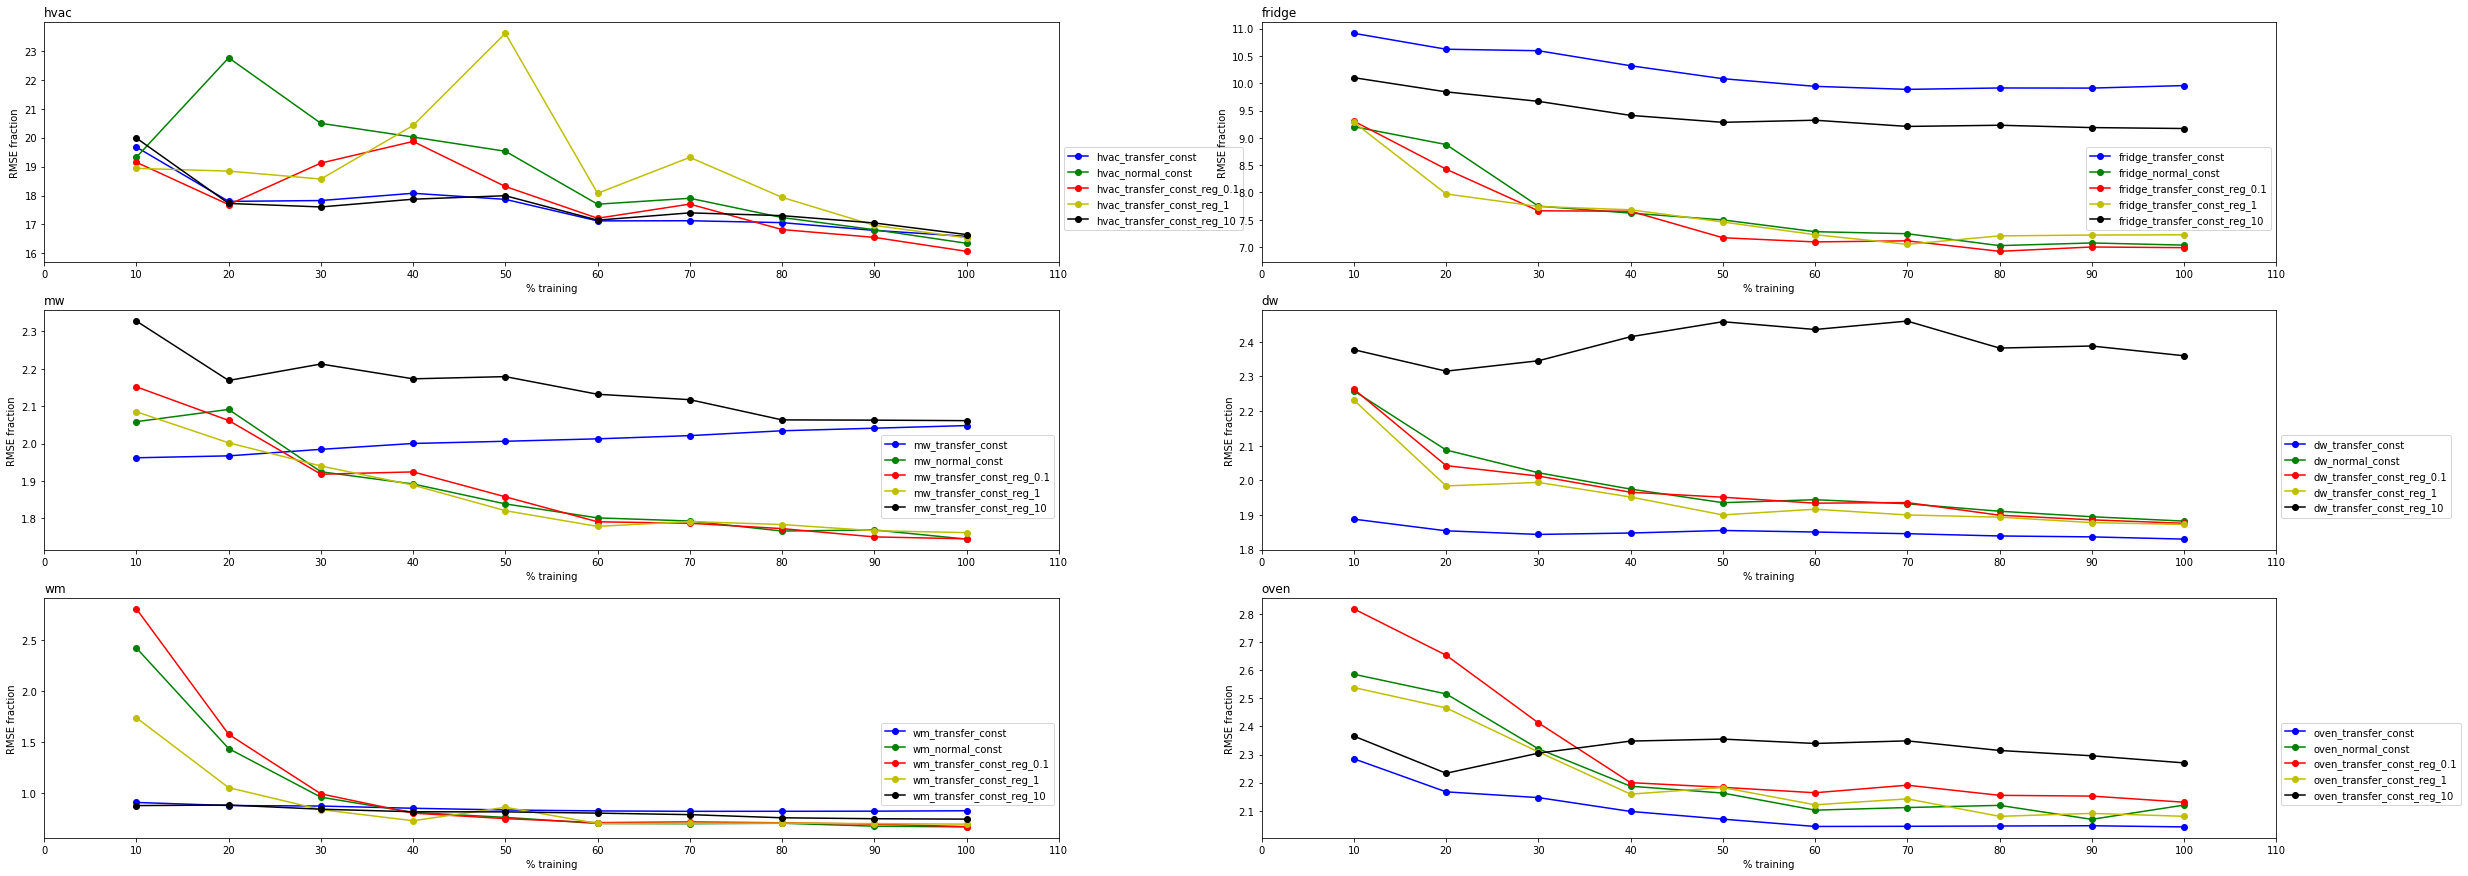

In [55]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(50, 80))
ax = axes.flatten()
count = 0

for appliance in APPLIANCES_ORDER[1:]:
#     print appliance
    df1 = all_out[appliance+ '_transfer_const']
    df2 = all_out[appliance+ '_normal_const']
    df3 = all_out[appliance+ '_transfer_const_reg_0.1']
    df4 = all_out[appliance+ '_transfer_const_reg_1']
    df5 = all_out[appliance+ '_transfer_const_reg_10']


    df = pd.concat([df1, df2, df3, df4, df5], axis=1)
    pd.DataFrame(df).plot(ax=ax[count],  figsize=(40, 15), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
    ax[count].legend(loc='best', bbox_to_anchor=(1.0, 0.5))


#     major_ticks = np.arange(0, 101, 20)   

    ax[count].set_xlabel("% training");
    ax[count].locator_params(tight=False, nbins=20, axis='x')
    ax[count].set_ylabel('RMSE fraction')
    ax[count].set_title(appliance, loc="left")
    count += 1
plt.savefig("./analysis/0711/regularization.pdf", bbox_inches="tight", dpi=300, format="pdf")